In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

In [5]:
# Load data
xtrain_data = pd.read_csv('XTrain.csv')
ytrain_data = pd.read_csv('YTrain.csv')
engine_data = np.array(pd.read_csv('Engine.csv'))
xtest_data = pd.read_csv('XTest.csv')
ytest_data  = pd.read_csv('YTest.csv')
engine_test_data = np.array(pd.read_csv('Engine_Test.csv'))

In [13]:
# Data saturation function
def saturation_RUL(inp_df, th):
    temp_data = np.array(inp_df)
    temp_data[temp_data > th] = th
    return temp_data


In [14]:
threshold = 130
ytrain_data['Remaining Cycles'] = saturation_RUL(ytrain_data['Remaining Cycles'], threshold)
ytest_data['Remaining Cycles'] = saturation_RUL(ytest_data['Remaining Cycles'], threshold)


In [15]:
# Training data transformation for LSTM
def Feature_Transform(xdata, engdata, window=30):
    n_samp = []
    engines = np.unique(engdata)
    for j in engines:
        local_df = xdata[engdata == j]
        num_samples = len(local_df) - window
        input_list = [np.expand_dims(np.atleast_2d(local_df.iloc[i:window+i,:]), axis=0) for i in range(num_samples)]
        if j == engines[0]:
            input_mat = np.concatenate(input_list, axis=0)
        else:
            input_mat = np.concatenate([input_mat, np.concatenate(input_list, axis=0)], axis=0)
        n_samp.append(num_samples)
    return input_mat, n_samp

In [16]:
# RUL transformation for LSTM
def RUL_Transform(ydata, engdata, window=30):
    engines = np.unique(engdata)
    for j in engines:
        local_df = ydata[engdata == j]
        num_samples = len(local_df) - window
        input_list = [np.expand_dims(local_df.iloc[window+i], axis=0) for i in range(num_samples)]
        if j == engines[0]:
            input_mat = np.concatenate(input_list, axis=0)
        else:
            input_mat = np.concatenate([input_mat, np.concatenate(input_list, axis=0)], axis=0)
    return input_mat.flatten()

In [17]:
window = 30
xtrain, temp = Feature_Transform(xtrain_data.drop('Cycles', axis=1), engine_data, window)
ytrain = RUL_Transform(ytrain_data, engine_data, window)
xtest, n_samp = Feature_Transform(xtest_data.drop('Cycles', axis=1), engine_test_data, window)
ytest = RUL_Transform(ytest_data, engine_test_data, window)

x_train, x_val, y_train, y_val = train_test_split(xtrain, ytrain, test_size=0.2, random_state=83)
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

features = xtrain.shape[2]


(14104, 30, 12) (3527, 30, 12) (14104,) (3527,)


In [18]:
# Build the model
model = Sequential([
    Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(window, features)),
    MaxPooling1D(pool_size=1),
    Dropout(0.1),
    LSTM(128, activation='tanh', return_sequences=True),
    LSTM(64, activation='tanh', return_sequences=True),
    LSTM(32, activation='tanh'),
    Dense(96, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1),
])
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# Fit the model
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), batch_size=128, verbose=2)


Epoch 1/10
111/111 - 15s - loss: 3714.1055 - val_loss: 1897.8817 - 15s/epoch - 138ms/step
Epoch 2/10
111/111 - 10s - loss: 1874.7766 - val_loss: 1896.7631 - 10s/epoch - 88ms/step
Epoch 3/10
111/111 - 10s - loss: 1837.7898 - val_loss: 932.7969 - 10s/epoch - 90ms/step
Epoch 4/10
111/111 - 10s - loss: 424.2959 - val_loss: 248.8406 - 10s/epoch - 86ms/step
Epoch 5/10
111/111 - 10s - loss: 205.6834 - val_loss: 174.1377 - 10s/epoch - 86ms/step
Epoch 6/10
111/111 - 10s - loss: 175.3207 - val_loss: 156.9565 - 10s/epoch - 86ms/step
Epoch 7/10
111/111 - 10s - loss: 163.6899 - val_loss: 142.0642 - 10s/epoch - 86ms/step
Epoch 8/10
111/111 - 10s - loss: 148.0133 - val_loss: 144.5866 - 10s/epoch - 86ms/step
Epoch 9/10
111/111 - 10s - loss: 143.9717 - val_loss: 145.3697 - 10s/epoch - 93ms/step
Epoch 10/10
111/111 - 10s - loss: 145.3002 - val_loss: 133.6640 - 10s/epoch - 86ms/step


In [19]:
# Make predictions
ypred = model.predict(xtest)

316/316 [==============================] - 7s 19ms/step


In [20]:
# Evaluate model performance
print('RMSE: ' + str(np.sqrt(mean_squared_error(ytest, ypred))))
print('R2: ' + str(r2_score(ytest, ypred)))

RMSE: 13.260032737417648
R2: 0.823329455843475


In [21]:
# Post-process predictions and actual values for plotting and evaluation
wind = 1
n_samp = np.array(n_samp)
samp = {'n_samp': n_samp, 'cumulative': n_samp.cumsum(), 'windowed': n_samp.cumsum()-wind}
samp = pd.DataFrame(samp)

ypred = ypred.flatten()
ytest_trunc = []
ypred_trunc = []
for i in range(len(samp)):
    if samp.iloc[i, 2] > 0:
        ytest_trunc.append(ytest[samp.iloc[i, 2]:samp.iloc[i, 1]])
        ypred_trunc.append(ypred[samp.iloc[i, 2]:samp.iloc[i, 1]])
ypred_truc = np.concatenate(ypred_trunc)
ytest_truc = np.concatenate(ytest_trunc)

In [22]:
# Evaluate truncated predictions
print('RMSE: ' + str(np.sqrt(mean_squared_error(ytest_truc, ypred_truc))))
print('R2: ' + str(r2_score(ytest_truc, ypred_truc)))

RMSE: 14.432988313196022
R2: 0.874363460064731


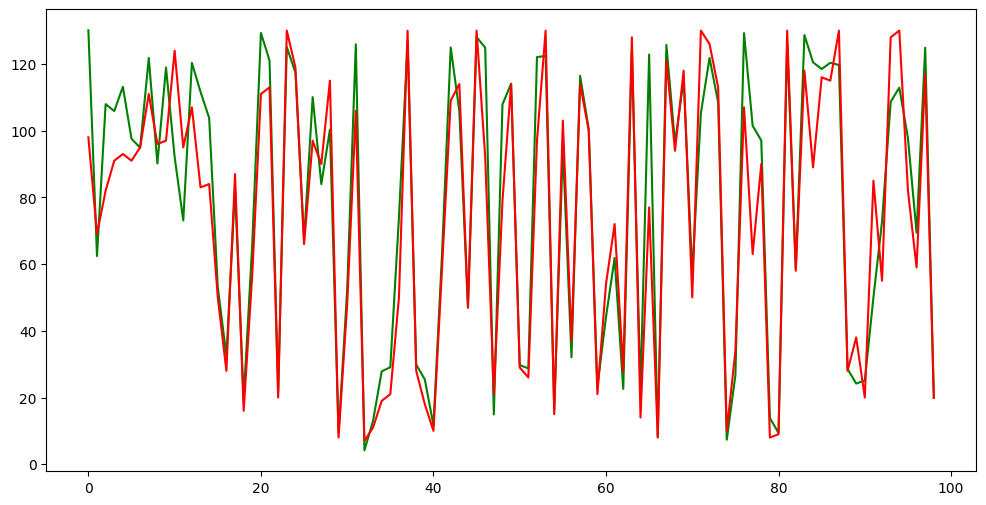

In [23]:
# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(ypred_truc, color='g')
plt.plot(ytest_truc, color='r')
plt.show()

<BarContainer object of 99 artists>

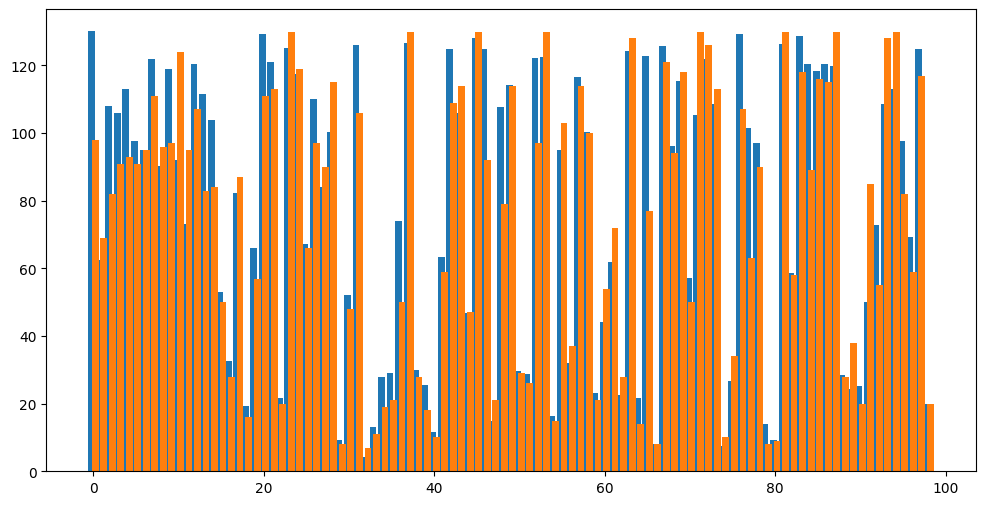

In [24]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(ytest_truc)) 
  
plt.bar(X_axis - 0.2, ypred_truc, label = 'Girls') 
plt.bar(X_axis + 0.2, ytest_truc,label = 'Boys') 
  
#plt.xticks(X_axis, X) 

In [28]:
ytest_truc[ypred_truc > 150]

array([], dtype=int64)

In [29]:
np.round(ypred_truc[ypred_truc > 150])

array([], dtype=float32)

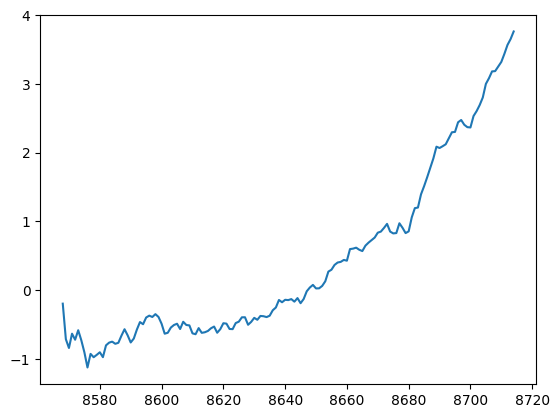

In [30]:
plt.plot(xtest_data[engine_test_data == 66]['PC1'])

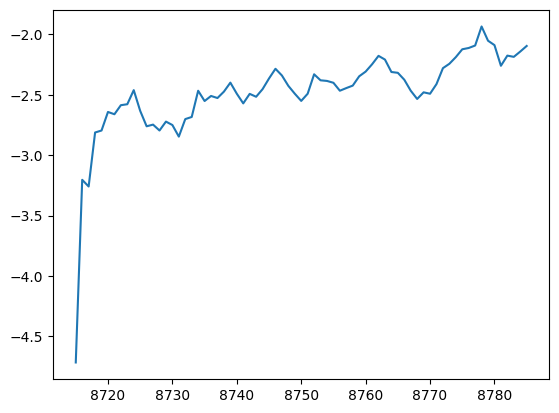

In [31]:
plt.plot(xtest_data[engine_test_data == 67]['PC1'])

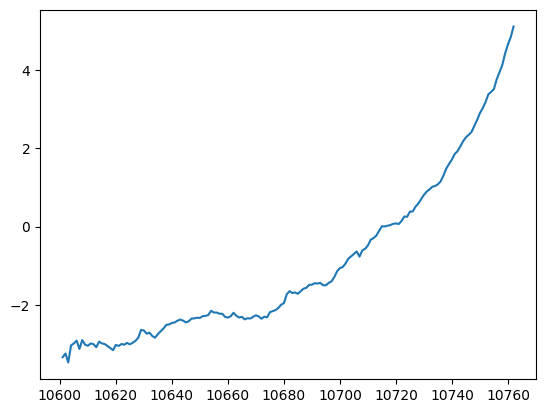

In [33]:
plt.plot(xtest_data[engine_test_data == 82]['PC1'])

In [34]:
ytrain_data

,Remaining Cycles
0,130
1,130
2,130
3,130
4,130
...,...
20626,4
20627,3
20628,2
20629,1
